# Seasonal Drink Classifier: Coffee Shop PCA + SVM

Can you teach a computer which **season** a drink belongs to using only flavor features?

Seasons:
- 🌸 spring
- ☀️ summer
- 🍂 fall
- ❄️ winter

You will mainly code two pieces:
1. PCA to visualize drinks in 2D flavor space
2. SVM to classify drinks into seasons

Everything else (data generation and scaling) is already done for you.

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 5)
sns.set(style="whitegrid")


## Dataset (PROVIDED)

Each drink has these features (0–10 scale):
- `spice`
- `temperature` (0 = iced, 10 = very hot)
- `flavor_notes` (richness / sweetness)
- `fruitiness`
- `color_tone` (0 = very light, 10 = very dark)
- `foaminess`

Label: `season` ∈ {spring, summer, fall, winter}

Run the code below to generate the dataset.

In [16]:
np.random.seed(42)

seasons = ["spring", "summer", "fall", "winter"]

def generate_season_drinks(season, n):
    base = {
        "spring": dict(spice=3, temperature=6, flavor=6, fruit=7, color=3, foam=4, sweetness=7),
        "summer": dict(spice=1, temperature=2, flavor=5, fruit=8, color=2, foam=2, sweetness = 10),
        "fall":   dict(spice=8, temperature=8, flavor=8, fruit=3, color=8, foam=7, sweetness=5),
        "winter": dict(spice=6, temperature=9, flavor=9, fruit=2, color=9, foam=8, sweetness=3)
    }
    params = base[season]

    def clip_norm(mean, std, size):
        return np.clip(np.random.normal(mean, std, size), 0, 10)

    return pd.DataFrame({
        "spice":        clip_norm(params["spice"], 1.2, n),
        "temperature":  clip_norm(params["temperature"], 1.2, n),
        "flavor_notes": clip_norm(params["flavor"], 1.2, n),
        "fruitiness":   clip_norm(params["fruit"], 1.2, n),
        "color_tone":   clip_norm(params["color"], 1.2, n),
        "foaminess":    clip_norm(params["foam"], 1.2, n),
        "season":       [season] * n
    })

drinks = pd.concat([
    generate_season_drinks(s, 20) for s in seasons
], ignore_index=True)

print(drinks.head())
print("\nDataset size:", drinks.shape)
print("\nSeason counts:\n", drinks["season"].value_counts())
print(f"\n✓ Loaded {len(drinks)} drinks across {drinks['season'].nunique()} seasons\n")


      spice  temperature  flavor_notes  fruitiness  color_tone  foaminess  \
0  3.596057     7.758779      6.886160    6.424991    2.736394   2.301555   
1  2.834083     5.729068      6.205642    6.777209    3.428535   3.495226   
2  3.777226     6.081034      5.861222    5.672398    4.773473   3.588743   
3  4.827636     4.290302      5.638676    5.564552    2.378076   3.037267   
4  2.719016     5.346741      4.225774    7.975031    2.029808   3.806457   

   season  
0  spring  
1  spring  
2  spring  
3  spring  
4  spring  

Dataset size: (80, 7)

Season counts:
 season
spring    20
summer    20
fall      20
winter    20
Name: count, dtype: int64

✓ Loaded 80 drinks across 4 seasons



### 🧠 Warm-Up Questions

Answer in your notebook or discuss with a partner:
1. Which features do you think matter most for telling seasons apart? Why?
2. Which two seasons do you think will be the hardest to separate? Why?
3. If you worked at a cafe, how might you use a "season predictor" like this in real life?

### A:
YOUR ANSWERS HERE

1. fruitiness
2. spring and winter. Both are cold season and does not have seasonal special spice like fall, or has temperature difference like summer
3. Use it to display the menu based on the season

## PART 1: Prepare and Scale Features (Done For You)

We will:
- Select numeric feature columns
- Scale them so all features are on a similar range

This is already implemented. Just run the cell.

In [17]:
features = [
    "spice", "temperature", "flavor_notes",
    "fruitiness", "color_tone", "foaminess"
]

X = drinks[features].values
y = drinks["season"].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Data scaled\n")
print(f"Original data shape: {X.shape}")
print(f"Scaled data shape: {X_scaled.shape}\n")


✓ Data scaled

Original data shape: (80, 6)
Scaled data shape: (80, 6)



### Checkpoint Questions
1. Why might it be a bad idea to run PCA and SVM on **unscaled** flavor features?
2. Which features do you expect to have the biggest impact on whether a drink feels "winter" vs "summer"?

### A:
YOUR ANSWERS HERE

1.
2.

----

## PART 2: Using PCA to Visualize Seasonal Flavor Space

Now **you** implement PCA.

Goals:
1. Fit PCA with 2 components on `X_scaled`
2. Transform the data into `X_pca`
3. Plot PCA Component 1 vs Component 2, with points colored by season

Think about: do certain seasons form clear clusters?

In [18]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)


print("PCA shape:", None if X_pca is None else X_pca.shape)
print("Explained variance ratio:", None if pca is None else pca.explained_variance_ratio_)

# narrows it down


PCA shape: (80, 2)
Explained variance ratio: [0.80167536 0.05957967]


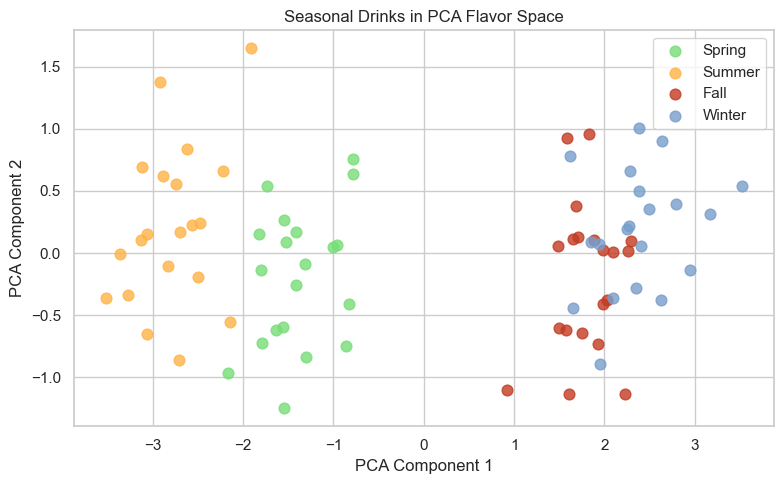

In [19]:
plt.figure(figsize=(8, 5))

seasons_unique = drinks["season"].unique()
palette = {
    "spring": "#77dd77",
    "summer": "#ffb347",
    "fall":   "#c23b22",
    "winter": "#779ecb"
}

for s in seasons_unique:
    mask = (y == s)
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask,1],
        label=s.capitalize(),
        alpha=0.8,
        s=60,
        c=palette[s]
    )

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Seasonal Drinks in PCA Flavor Space")
plt.legend()
plt.tight_layout()
plt.show()


### PCA Reflection
Answer in the markdown cell below:

1. Which seasons look most **separated** in your PCA plot? Which seasons overlap?
2. If you had to name each PCA axis like a TikTok trend, what would you call them?
   - Example: "Cozy vs Refreshing" or "Spicy & Hot vs Cool & Light"
3. If you added a new feature like `sweetness`, how do you think that might change the PCA picture?

### A:
YOUR ANSWERS HERE

1. Spring and summer, fall with winter
2.
3.

----

## PART 3: SVM – Build a Season Classifier

Now you will train an **SVM classifier** using the scaled features.

Steps:
1. Split `X_scaled` and `y` into train and test sets
2. Create an SVM with an RBF kernel
3. Fit the model on the training data
4. Predict on the test data
5. Print a classification report

Try to think: will the model confuse any seasons? Which ones?

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y,
    test_size=0.3,
    random_state=0,
    stratify=y
)

svm_clf = SVC(kernel='rbf', gama = 'scale', C=1.0, )

y_pred = None

print("Classification report:\n")
print(None)


TypeError: Expected sequence or array-like, got <class 'NoneType'>

### SVM Evaluation Questions

1. Look at the **precision** and **recall** for each season.
   - Which season is easiest for the model?
   - Which is hardest?
2. Do your PCA clusters match what the SVM report says? For example, if two seasons overlapped in PCA, does the model confuse them?
3. If you could collect **real cafe data**, what extra features would you add to help the model (examples: price, milk type, size, toppings)?

### A:
YOUR ANSWERS HERE

1.
2.
3.

----

## PART 4: Try Your Own Drinks ☕✨

Create your own drinks and see what season the model predicts.

Think of 2–4 fun drink names and decide their flavor numbers:
- Example names:
  - "Caramel Cloud Dream"
  - "Iced Strawberry Matcha Glow"
  - "Mocha Midnight Storm"

Then run the code below after your SVM is trained.

Before you run it, **guess** the season for each drink yourself. Then compare with the model.

In [ ]:
new_drinks = pd.DataFrame([
    {"name": "Caramel Cloud Dream", "spice": 4, "temperature": 8, "flavor_notes": 9,
     "fruitiness": 2, "color_tone": 7, "foaminess": 9},
    {"name": "Iced Strawberry Matcha Glow", "spice": 2, "temperature": 3, "flavor_notes": 6,
     "fruitiness": 9, "color_tone": 3, "foaminess": 4}
])

feature_cols = ["spice", "temperature", "flavor_notes", "fruitiness", "color_tone", "foaminess"]

X_new = None
pred_seasons = None

new_drinks["predicted_season"] = None
print(new_drinks[["name", "predicted_season"]])


### Final Reflection

1. Did the model agree with your own guesses for your custom drinks? If not, what would you change about the flavor numbers to "convince" the model?
2. Do you think season labels for drinks are **objective** (based on features) or **subjective** (based on people’s feelings)? How does that affect modeling?
3. Imagine this model is part of a cafe app that recommends drinks based on the weather. What other data (outside of the drink itself) would you include?

### A:
YOUR ANSWERS HERE

1.
2.
3.

### Key Takeaway 🔑
PCA helps us **see** patterns in high-dimensional flavor data, and SVM learns **boundaries** between seasons in that space. Together, they turn vibes like "cozy fall latte" into patterns a computer can understand.